# Primer on Markov Chain Monte Carlo (MCMC) sampling

This is my simplified version of the (much better) blog post by Thomas Weicki which can be found [here](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/). I wrote this as I wanted to highlight some different points are simplify others.

## Bayes formulae and the aim of MCMC sampling

Defining $x$ as some data and $\theta$ as model-parameters (of some as yet undefined model), Bayes formulae is

$$ P(\theta | x) = \frac{P(x| \theta) P(\theta)}{P(x)} $$

which is the joint posterior probability distrubution of $\theta$ given $x$.

Ultimately, the goal of MCMC sampling is **to make inferences about $\theta$, given $x$ **. To this extent, the denominator of Bayes formulae (the difficult-to-compute evidence) is irrelevant.Therefore, we may write the *joint probability distribution* of the model parameters $\theta$ as:

$$ P(\theta | x) \propto \underbrace{P(x| \theta)}_{\textrm{the likelihood}} \overbrace{P(\theta)}^\textrm{the prior}$$

In what follows, we build a simple MCMC sampler which is applied to some simple data.

## Example using code

First, import somethings

In [38]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, uniform

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

### Generate some data

Let our *data* consist of $N=50$ draws from a normal distribuition:

In [98]:
data = np.random.normal(0, 1, 50)
print data[:10]

[-0.00332181  2.02525431 -0.19994766 -0.13305089  0.82049702 -0.69675314
 -1.70797874  1.34685598 -2.04588357  0.23402848]


We can plot a histogram to get a feel for how it is distributed:

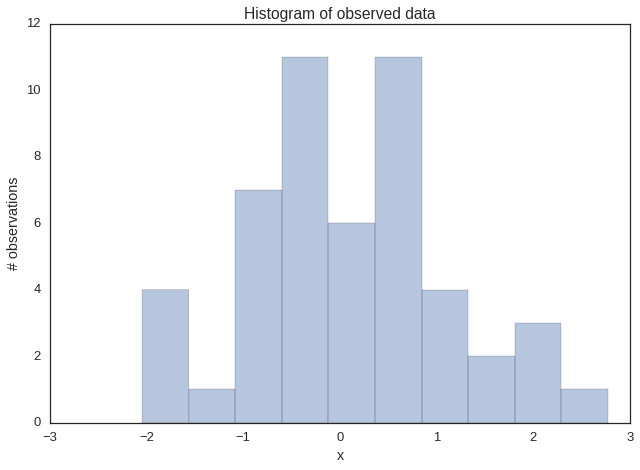

In [99]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax, bins=10)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

### Model of the data:

Let us model the data as being Gaussian, with a fixed standard deviation $\sigma=1$; this is an assumption going into the analysis, we could just as well pick any other probabilistic model. The likelihood for a data point $x_i$, given the Gaussian model, is therefore

$$P(x_i| \mu, \sigma{=}1) \sim \textrm{Normal}(x_i; \mu, \sigma{=}1),$$

such that $\mu$ is our only model parameter.

We have $N$ data points though, so the **likelihood** for the set of all data point $\mathbf{x}={x_i}$ is

$$P(\mathbf{x}| \mu, \sigma{=}1) \sim \prod_{i}^{N} \textrm{Normal}(x_i; \mu, \sigma{=}1).$$

Having obtained the likelihood, we now need the **prior** in order to calculate the joint probability distribution of all the model parameters (which in this case is just $\mu$). Let us choose this to be

$$P(\mu) = \textrm{Unif}(\mu; \textrm{lower}{=}{-}10, \textrm{upper}{=}10)$$

Then finally, our posterior probability distribution for $\mu$ is

$$P(\mu | \mathbf{x}) = P(\mathbf{x}| \mu, \sigma{=}1) P(\mu)= \prod_{i}^{N} \textrm{Normal}(x_i; \mu, \sigma{=}1) \times \textrm{Unif}(\mu; \textrm{lower}{=}{-}10, \textrm{upper}{=}10)$$

## MCMC Sampling

### Detail of each step

### Initialise

We will now start sampling, to begin we need an initial point. Usually one chooses this randomly, but here we pick a starting value of $\mu=1$

In [138]:
mu_current = 1

#### Proposal
Next, we propose a new point in parameter space (this is the Markov chain part of MCMC). There are many ways to do this, but we will use the **Metropolis sampler** which proposes a new value based on a normal distribution (unrelated to the model normal distribution) with mean given by the current value of $\mu$ and a standard deviation given by a constant: ``proposal_width``

In [139]:
proposal_width = 0.5
mu_proposal = norm(mu_current, proposal_width).rvs()
print mu_proposal

1.08851941964


#### Evaluate the proposed jump

In [141]:
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu        
prior_current = uniform(-10, 20).pdf(mu_current) # Note, this IS unif(-10, 10) - see docs
prior_proposal = uniform(-10, 20).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

print 'Current probability={:1.2e}, proposed probability={:1.2e}'.format(p_current, p_proposal)

Current probability=2.19e-42, proposed probability=3.78e-44


At this point we need to introduce the Monte-Carlo part. The trick is we calculate a ratio of the two probabilities, a so-called accepetance probability

In [142]:
p_accept = p_proposal / p_current
print p_accept

0.017253743708


Then, we compare it against a number drawn from a uniform distribution on $[0,1]$. If `p_proposal` is larger than `p_current`, we will **always** accept, but if it is smaller then we occasionally accept.

In [144]:
accept = np.random.rand() < p_accept
print accept
if accept:
    # Update position
    cur_pos = proposal

False


This process is repeated and it can be shown that the equilibrium distribution of this (the MCMC) algorithm is equivalent to the desired distribution (of the model parameters). There are many choices in this, we have used the most basic (and unsurprisingly poor) ones.

### Putting it all together

Here is a function which puts all of the previous steps together for simplicity:

In [124]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = uniform(-10, 20).pdf(mu_current) # Note, this IS unif(-10, 10) - see docs
        prior_proposal = uniform(-10, 20).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        p_accept = p_proposal / p_current

        accept = np.random.rand() < p_accept

        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

### Short chain example

We now run the chain for a few steps to show the progress:

In [149]:
samples = sampler(data, samples=100, mu_init=1, proposal_width=0.1)

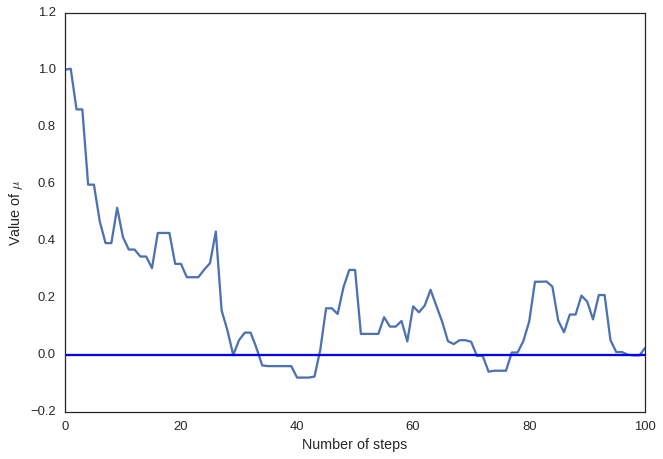

In [150]:
plt.plot(np.arange(len(samples)), samples)
plt.xlabel('Number of steps')
plt.ylabel('Value of $\mu$')
plt.axhline(0)
plt.show()

### Repeat for many steps

Then we repeat for thousands of steps

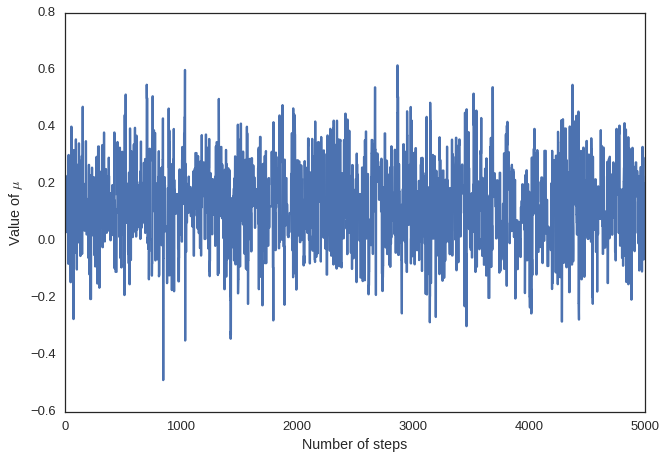

In [152]:
samples = sampler(data, samples=5000, mu_init=samples[-1])
plt.plot(np.arange(len(samples)), samples)
plt.xlabel('Number of steps')
plt.ylabel('Value of $\mu$')

Finally, our estimate of the posterior can be made by plotting a histogram (or equivalent) of the samples from this chain (taking care to excluse any 'burn-in' period).

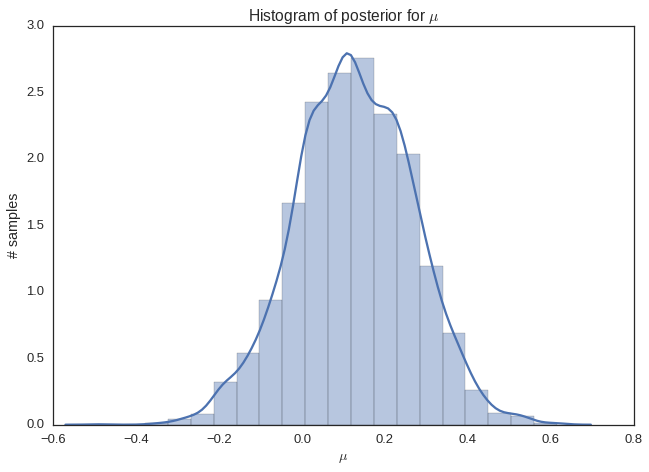

In [153]:
ax = plt.subplot()
sns.distplot(samples, ax=ax, bins=20)
_ = ax.set(title='Histogram of posterior for $\mu$', xlabel='$\mu$', ylabel='# samples');